In [1]:
pip install arch

   ---------------------------------------- 0.0/925.2 kB ? eta -:--:--
   --------------------------------------- 925.2/925.2 kB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------------ --------------------------- 3.7/11.5 MB 18.4 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.5 MB 10.1 MB/s eta 0:00:01
   ------------------- -------------------- 5.5/11.5 MB 9.2 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.5 MB 7.3 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.5 MB 6.8 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.5 MB 6.2 MB/s eta 0:00:01
   ------------------------------- -------- 8.9/11.5 MB 5.9 MB/s eta 0:00:01
   --------------------------------- ------ 9.7/11.5 MB 5.7 MB/s eta 0:00:01
   ------------------------------------ --- 10.5/11.5 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.5 MB 5.2 MB/s eta 0:00:01
   --

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import openpyxl
sns.set()
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, kpss
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

# Load and plot data

In [100]:
returns = pd.read_excel('portfolio_returns.xlsx').set_index('Date').rename(columns={0: 'returns'})
returns.head()

,returns
Date,
2020-01-03,-0.016735
2020-01-06,0.010083
2020-01-07,0.000032
2020-01-08,0.009340
2020-01-09,0.002688


Days with high volatilities appear in cluster, they are not evenly distributed over time. This is the same for low volatility days.  
This clustering is evidence of **conditional heteroscedasticity**.  

The plot below highlights the returns which are in the top decile of the sample.

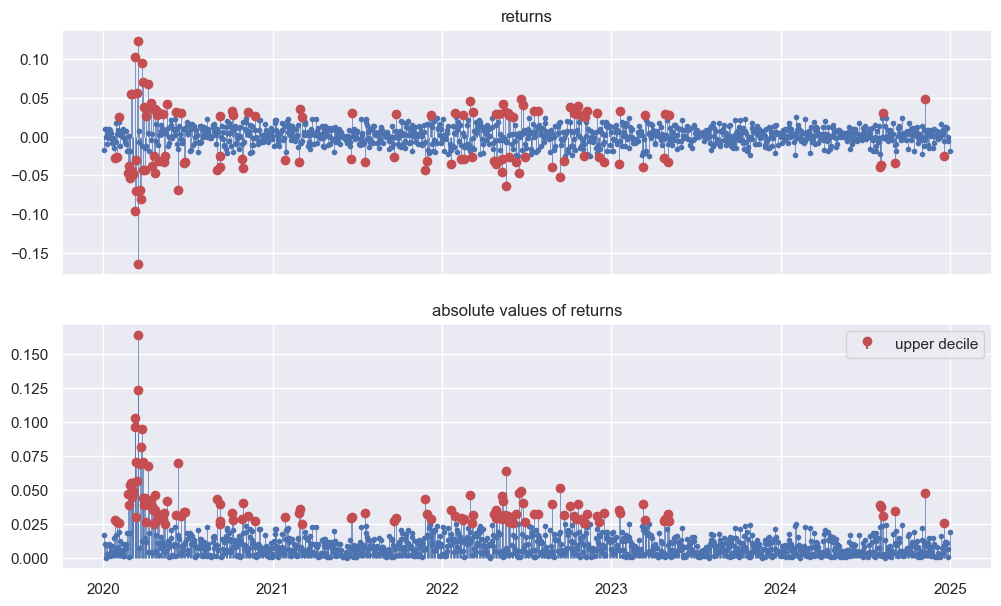

In [6]:
def plot_deciles(data):
    abs_vals = data.abs()
    #sq_vals = data ** 2
    upper_decile = abs_vals.quantile(0.9)
    upper_decile_mask = abs_vals > upper_decile

    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7), sharex=True)
    markerline, stemlines, baseline = ax1.stem(data.index, data['returns'])
    markerline.set(marker='.')
    stemlines.set(lw=0.5)
    baseline.set(lw=0)
    markerline, stemlines, baseline = ax1.stem(data[upper_decile_mask].index, data[upper_decile_mask], label="upper decile")
    stemlines.set(lw=0, color='r')
    markerline.set(color='r')
    baseline.set(lw=0)
    ax1.set_title("returns")

    markerline, stemlines, baseline = ax2.stem(abs_vals.index, abs_vals['returns'])
    markerline.set(marker='.')
    stemlines.set(lw=0.5)
    baseline.set(lw=0)
    markerline, stemlines, baseline = ax2.stem(abs_vals[upper_decile_mask].index, abs_vals[upper_decile_mask], label="upper decile")
    stemlines.set(lw=0, color='r')
    markerline.set(color='r')
    ax2.set_title("absolute values of returns")
    baseline.set(lw=0)
    ax2.legend()

plot_deciles(returns)

# Test for Normality

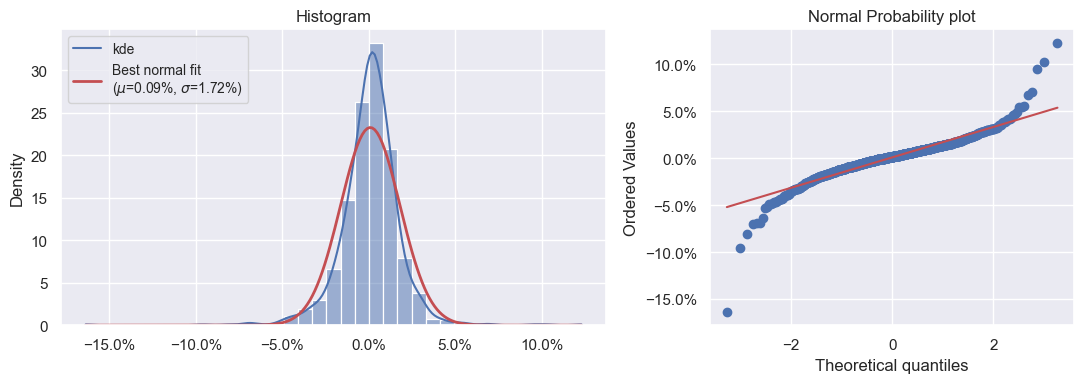

In [7]:
def plot_qqplot(data, percent):
    fig, (ax_hist, ax_normplot) = plt.subplots(1, 2, figsize=(11,4), width_ratios=(3,2))
    
    # plot an histogram + kde + MLE normal fit
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 200)
    pdf_norm = stats.norm.pdf(x, loc=mu, scale=sigma)
    sns.histplot(data, ax=ax_hist, bins=35, kde=True, stat='density', legend=False)
    ax_hist.plot(x, pdf_norm, c='r', lw=2)    
    label = "Best normal fit\n"
    label += fr"($\mu$={mu:.2%}, $\sigma$={sigma:.2%})"
    lines = ax_hist.get_lines()
    ax_hist.legend(lines, ['kde', label], fontsize='small', loc='upper left')
    ax_hist.set_title("Histogram")

    # plot a Normal probability plot
    if len(data.values.shape)==2:
        val = data.values[:,0]
    else:
        val = data.values
    stats.probplot(val, plot=ax_normplot)
    ax_normplot.set_title("Normal Probability plot")

    if percent:
        ax_hist.xaxis.set_major_formatter(mtick.PercentFormatter(1))
        ax_normplot.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    fig.tight_layout()

plot_qqplot(returns, percent=True)

In [8]:
stats.jarque_bera(returns)

SignificanceResult(statistic=np.float64(7891.196849691307), pvalue=np.float64(0.0))

# Tests of stationarity

### Augmented Dickey-Fuller unit root test
[Augmented Dickey-Fuller test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html): the **Null hypothesis** is that there is a unit root vs. the **Alternative hypothesis** of stationarity. (Test estimates a regression set by the `regression` parameter).  

In [9]:
def print_adf_test(x):
    regressions = {'no constant, no trend': 'n',
                   'constant and trend': 'ct',
                   'constant only': 'c'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [10]:
res = print_adf_test(returns)

,test statistic,p-value
"no constant, no trend",-11.4605,0.0
constant and trend,-11.7382,0.0
constant only,-11.7305,0.0


### KPSS test
The null hypothesis for the [KPSS test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html) is
- `regression='c'`: the data is stationary around a constant (default).
- `regression='ct'`: the data is stationary around a trend.

In [11]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [12]:
print_kpss_test(returns)

C:\Users\quent\AppData\Local\Temp\ipykernel_28908\3569781587.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')
C:\Users\quent\AppData\Local\Temp\ipykernel_28908\3569781587.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.0611,0.1
constant and trend,0.0493,0.1


# Testing for autocorrelation

### Plot the *autocorrelation* function and the *partial autocorrelation* function
- [plot_acf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)
- [plot_pacf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)

In [14]:
def plot_acf_pacf(x, lags=30):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(x, lags=lags, ax=axs[0])
    plot_pacf(x, lags=lags, ax=axs[1], method='yw')
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    for ax in axs:
        ax.hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
        ax.legend()

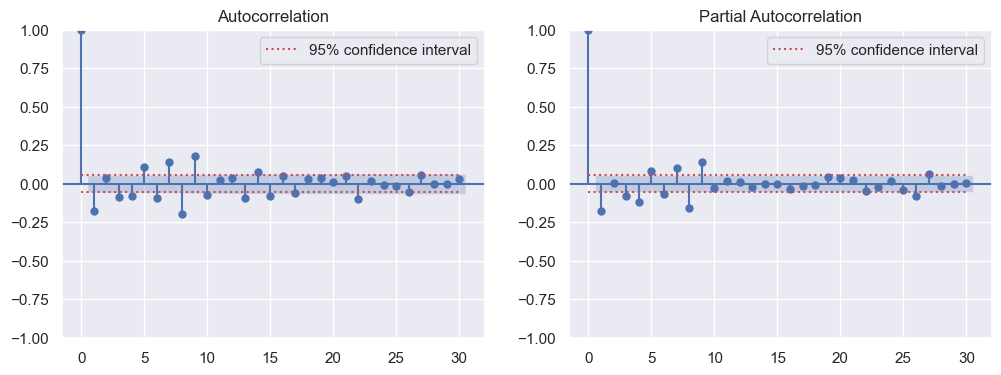

In [15]:
plot_acf_pacf(returns)

### Another view of autocorrelation

In [16]:
def scatter_plots(data, lags):
    fig, axs = plt.subplots(1, 2, figsize=(12,4), subplot_kw={'aspect': 'equal'})
    for ax, lag in zip(axs, lags):
        ax.scatter(data[:-lag], data[lag:], alpha=0.2, marker='.')
        ax.set_ylabel("data at time $t$")
        ax.set_xlabel(f"data at time $t-${lag}")
        ax.set_title(f"Autocorrelation at lag {lag}")

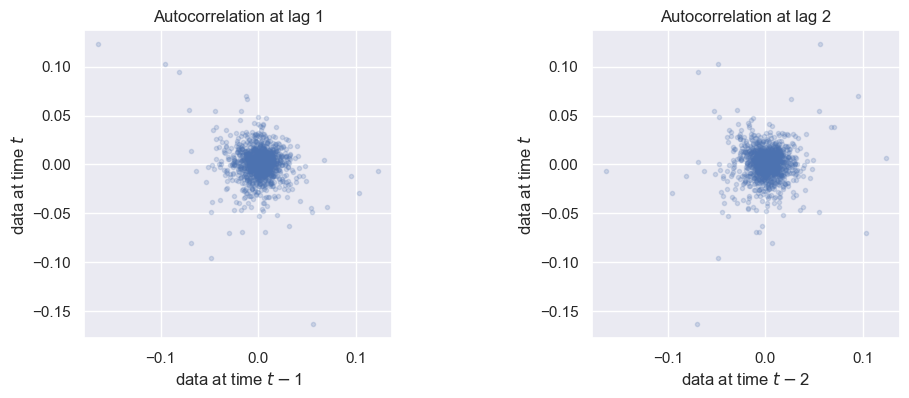

In [17]:
scatter_plots(data=returns, lags=[1, 2])

The losses seem mostly independent, except for the large losses and gains during the pandemic in 2020.  

We start again the analysis without the year 2020.

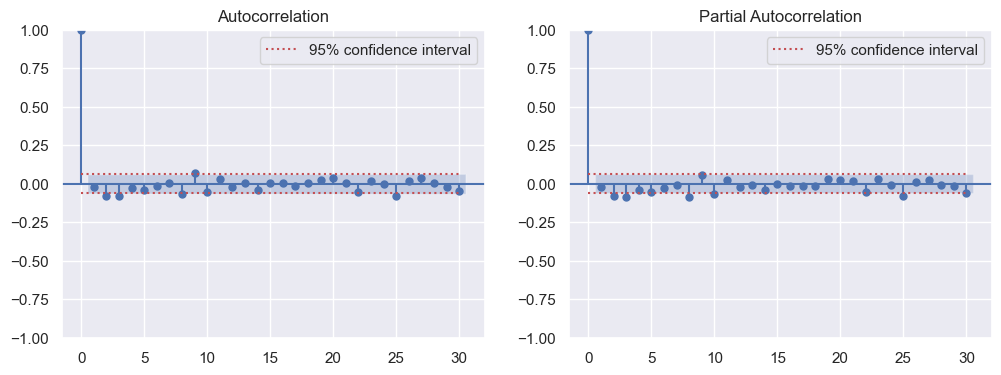

In [101]:
returns_2021 = returns['2021':].copy()
plot_acf_pacf(returns_2021)

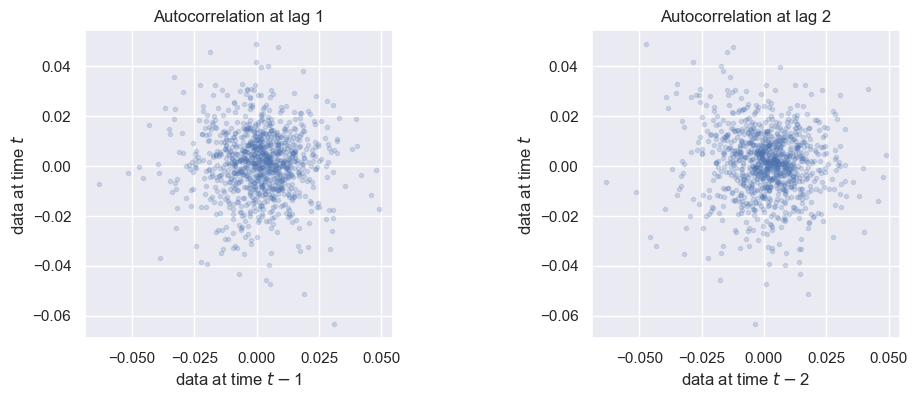

In [19]:
scatter_plots(data=returns_2021 , lags=[1, 2])

In [91]:
res = print_adf_test(returns_2021)

,test statistic,p-value
"no constant, no trend",-11.2876,0.0
constant and trend,-11.8027,0.0
constant only,-11.8065,0.0


### Ljung-Box Q test

The [`acf` function](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html) returns the acf values.  
With the parameter `qstat=True`, it returns the Ljung-Box Q statistic and its p-values, computed for all lags up to `nlags`.

In [21]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)

In [22]:
test_lags = np.array([1, 2, 3, 5, 7, 10])
print_acf(returns_2021, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,0.46,49.68
up to lag 2,6.79,3.35
up to lag 3,13.47,0.37
up to lag 5,15.84,0.73
up to lag 7,16.06,2.46
up to lag 10,28.77,0.14


# Testing for Conditional Heteroscedasticity

### Autocorrelation in the squared values

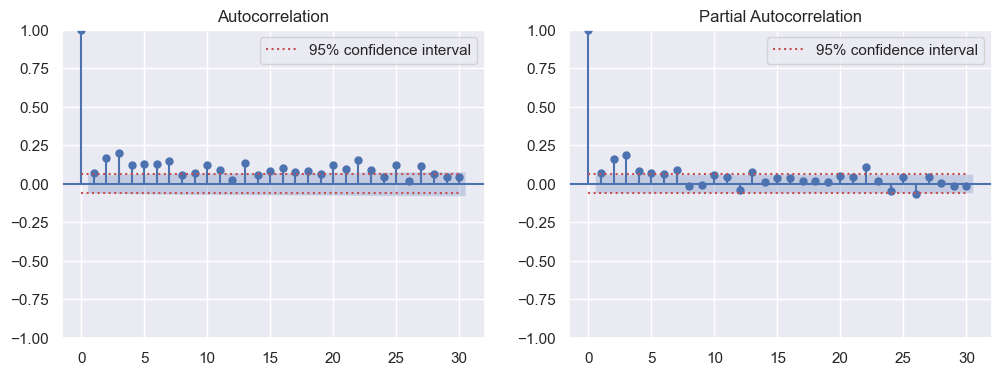

In [23]:
plot_acf_pacf(returns_2021**2)

In [24]:
print_acf(returns_2021**2, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,4.60,3.2
up to lag 2,32.63,0.0
up to lag 3,72.44,0.0
up to lag 5,104.91,0.0
up to lag 7,144.24,0.0
up to lag 10,168.04,0.0


### Engle’s Test for Autoregressive Conditional Heteroscedasticity
[het_arch](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_arch.html)  

*The Null Hypothesis is that there is no ARCH effect*.

In [25]:
def print_engle_test(x):
    res = het_arch(x, nlags=min(10, len(x)//5))
    df = pd.DataFrame(data = np.array(res).reshape(2,2),
                      columns=['test statistic', 'p-value'],
                      index=['Lagrange Multiplier', 'F test'])
    print("Engle's ARCH Test")
    display(df.round(4))
    return df

Apply to the returns.

In [102]:
res = print_engle_test(returns_2021)

Engle's ARCH Test


,test statistic,p-value
Lagrange Multiplier,90.1133,0.0
F test,9.8000,0.0


# Fitting a GARCH(p,q) model

**Note**: *In the `arch` library, the parameter $p$ is for the number of ARCH lags and the parameter $q$ is for the number of GARCH lags.*  

We use a GARCH($p, q$) model with a mean equal to 0 with the parameter `mean='Zero'`. The returns are driven by the following equations:  
$$\begin{align}
r_t &= \sigma_t \varepsilon_t\\
\sigma_t^2 &= \omega + \sum_{i=1}^p \alpha_i r_{t-i}^2  + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
\end{align}$$   

We use the `arch` library.
1. create an `ARCHmodel object` using the model constructor `arch_model()`.
2. use the `fit()` method of the `ARCHmodel object` and store the result.
3. the result is an object of the class `ARCHModelResult` that we can now use.

*links:*
- [Introduction](https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.univariate.arch_model) to ARCH Models.
- [`arch` library](https://arch.readthedocs.io/en/latest/index.html).
- [Model Constructor `arch_model`](https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.univariate.arch_model).
- [`ARCHModel` class](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModel.html).
  - [`fit` method](https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModel.fit.html) of the class.
- [`ARCHModelResult` class](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html).

The [ARCHmodel](https://arch.readthedocs.io/en/latest/univariate/introduction.html#arch.univariate.arch_model) allows to model ARMA+GARCH processes. We only need the GARCH part as our process is a white noise.  
We center the time series to use `mean='zero'` for the conditional mean model.

In [103]:
returns_2021 -= returns_2021.mean()
returns_2021.mean()

returns   -1.935150e-19
dtype: float64

## Selecting a model with Information Criteria

This function estimate some GARCH models and store their AIC and BIC values in two DataFrame.

In [104]:
def select_garch(x, max_arch=2, max_garch=2, mean='Zero'):
    """
    Compute and store the AIC and BIC values for all GARCH models
    with 1 <= ARCH lags  <= max_arch
    and  0 <= GARCH lags <= max_garch
    Returns two DataFrames, first with AIC values, second with BIC values
    """
    # create the row and columns indices for the DataFrame
    row_index = pd.Index(data=np.arange(max_arch)+1, name='ARCH Lags')
    col_index = pd.Index(data=np.arange(max_garch+1), name='GARCH Lags')
    
    # create the DataFrames with zeros everywhere
    aic = pd.DataFrame(data=np.zeros((max_arch, max_garch+1)),
                       index=row_index,
                       columns=col_index)
    bic = pd.DataFrame(data=np.zeros((max_arch, max_garch+1)),
                       index=row_index,
                       columns=col_index)
    
    # loop on ARCH lags and GARCH lags
    for i in range(max_arch):
        for j in range(max_garch+1):
            # estimate the model and save AIC and BIC
            model = arch_model(x, p=i+1, q=j, mean=mean)
            res = model.fit(update_freq=0, disp='off')
            aic.iloc[i, j] = res.aic
            bic.iloc[i, j] = res.bic
    
    # find the row and column index of the minimum value in the AIC DataFrame
    # and store the corresponding order of the GARCH model in a tuple
    r_min, c_min = np.unravel_index(np.argmin(aic), aic.shape)
    aic_min_order = (row_index[r_min], col_index[c_min])
    
    # same for BIC
    r_min, c_min = np.unravel_index(np.argmin(bic), bic.shape)
    bic_min_order = (row_index[r_min], col_index[c_min])
    
    # display the results
    display(aic.round(1))
    print(f'AIC selected order: {aic_min_order}')
    display(bic.round(1))
    print(f'BIC selected order: {bic_min_order}')
    
    # return the two DataFrame
    return aic, bic

Apply this function to our data.  
We scale the returns by a factor 100 for better numerical results.

In [105]:
aic, bic = select_garch(100*returns_2021, max_arch=4, max_garch=4, mean='constant')

GARCH Lags,0,1,2,3,4
ARCH Lags,,,,,
1,3446.4,3338.1,3340.1,3342.1,3343.0
2,3397.8,3338.2,3340.0,3341.2,3341.7
3,3358.0,3340.2,3342.0,3342.6,3343.6
4,3350.5,3342.2,3344.1,3344.6,3345.6


AIC selected order: (np.int64(1), np.int64(1))


GARCH Lags,0,1,2,3,4
ARCH Lags,,,,,
1,3461.2,3357.8,3364.7,3371.5,3377.4
2,3417.4,3362.7,3369.5,3375.5,3381.0
3,3382.6,3369.6,3376.4,3381.9,3387.8
4,3380.0,3376.6,3383.4,3388.8,3394.7


BIC selected order: (np.int64(1), np.int64(1))


## Fit the model selected by AIC and BIC
Use the  `summary()` method of the [`ARCHModelResult` object](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.base.ARCHModelResult.html) to display the estimated model.  

Fit a **GARCH(1,1)** model to the data.

In [106]:
model = arch_model(100*returns_2021, p=1, q=1, mean='Zero')
res_garch11 = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5350.676645168126
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1783.462665067686
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1973.7419687641132
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1665.151157035641
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1665.1447659109504
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1665.1444445185584
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1665.1444281735558
Iteration:      8,   Func. Count:     42,   Neg. LLF: 1665.1444281751728
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1665.1444281735558
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


In [107]:
res_garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1665.14
Distribution:                  Normal   AIC:                           3336.29
Method:            Maximum Likelihood   BIC:                           3351.02
                                        No. Observations:                 1004
Date:                Tue, Apr 15 2025   Df Residuals:                     1004
Time:                        22:31:00   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0814  7.909e-02      1.029      0.303 [-7.361e-02,  0.236]
alpha[1]       0.1139  7.422e-02      1.535      0.125 [-3.155e-02,  0.259]
beta[1]        0.8432      0.110      7.651  1.997e-14    [  0.627,  1.059]
===========================================================================

Covariance estimator: robust
"""

In [50]:
#model = arch_model(100*returns['2023':], p=1, q=1, mean='Zero')
#res_garch11 = model.fit()
#res_garch11.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 921.625824898387
Iteration:      2,   Func. Count:     13,   Neg. LLF: 765.5736063608994
Iteration:      3,   Func. Count:     19,   Neg. LLF: 786.9297993805963
Iteration:      4,   Func. Count:     24,   Neg. LLF: 749.5586994562439
Iteration:      5,   Func. Count:     29,   Neg. LLF: 749.0935598691709
Iteration:      6,   Func. Count:     33,   Neg. LLF: 749.0926065434587
Iteration:      7,   Func. Count:     37,   Neg. LLF: 749.0925057372303
Iteration:      8,   Func. Count:     41,   Neg. LLF: 749.092462729327
Iteration:      9,   Func. Count:     44,   Neg. LLF: 749.0924627292984
Optimization terminated successfully    (Exit mode 0)
            Current function value: 749.092462729327
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -749.092
Distribution:                  Normal   AIC:                           1504.18
Method:            Maximum Likelihood   BIC:                           1516.83
                                        No. Observations:                  501
Date:                Tue, Apr 15 2025   Df Residuals:                      501
Time:                        21:34:10   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2261  7.873e-02      2.871  4.087e-03 [7.175e-02,  0.380]
alpha[1]       0.1286  4.891e-02      2.629  8.560e-03 [3.273e-02,  0.224]
beta[1]        0.6860  8.345e-02      8.221  2.022e-16   [  0.522,  0.850]
==========================================================================

Covariance estimator: robust
"""

##  Residuals analysis

We study the **standardized residuals**, that is $\varepsilon_t = r_t / \sigma_t$, which are in the `std_resid` attribute of the `ARCHModelResult` class.  

Not that the model has been fitted on `100*returns`. The output must be scaled accordingly.

In [108]:
model = arch_model(100*returns_2021, p=1, q=1, mean='Zero')
res_garch11 = model.fit()
residuals = res_garch11.std_resid / 100

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5350.676645168126
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1783.462665067686
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1973.7419687641132
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1665.151157035641
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1665.1447659109504
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1665.1444445185584
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1665.1444281735558
Iteration:      8,   Func. Count:     42,   Neg. LLF: 1665.1444281751728
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1665.1444281735558
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8


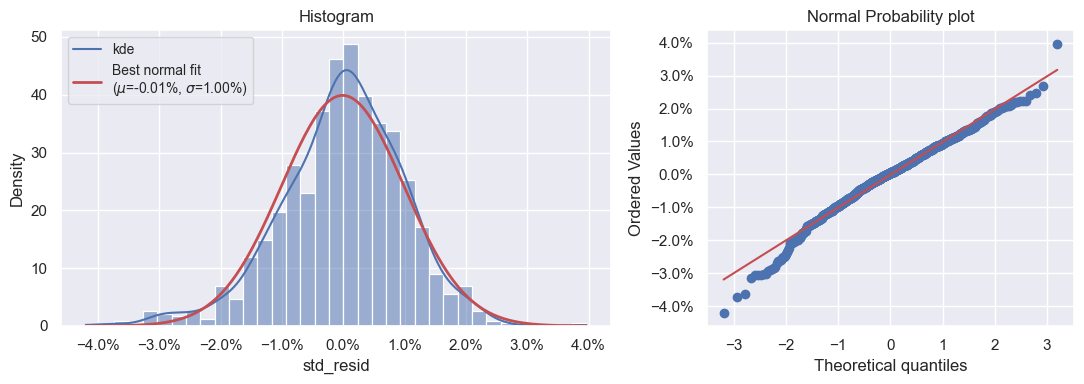

In [109]:
plot_qqplot(residuals, percent=True)

In [110]:
stats.jarque_bera(residuals)

SignificanceResult(statistic=np.float64(66.42330719486475), pvalue=np.float64(3.7701801952956146e-15))

# Prediction of Conditional Volatility

In [111]:
returns_2021['cond_vol'] = res_garch11.conditional_volatility / 100
returns_2021.tail()

,returns,cond_vol
Date,,
2024-12-23,0.010641,0.012236
2024-12-24,0.009790,0.012136
2024-12-26,-0.001122,0.011968
2024-12-27,-0.007170,0.011360
2024-12-30,-0.019554,0.011082


In [112]:
def plot_volatilities(data, period=20, lam=0.92):
    rolling_vol = data['returns'].rolling(period).std()
    EWMA_vol = data['returns'].ewm(alpha=1-lam).std()
    GARCH_vol = data['cond_vol']
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(16,10))

    markerline, stemlines, baseline = ax1.stem(data.index, data['returns'], label='returns')
    markerline.set(marker='.')
    stemlines.set(lw=0.5)
    baseline.set(c='k', ls='--', lw=0.5)
    ax1.fill_between(data.index, data['cond_vol'], -data['cond_vol'], color='gold', alpha=0.5, label=chr(177)+"1 conditional std dev band")
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax1.set_ylabel("returns")
    ax1.legend()

    ax2.plot(GARCH_vol, lw=2, label="GARCH conditional volatility")
    ax2.plot(rolling_vol, ls='--', label=f"{period}-days rolling volatility")
    ax2.plot(EWMA_vol, ls='-.', label=fr"EWMA volatility ($\lambda$={lam})")
    ax2.axhline(0, ls=':', c='k', lw=0.5)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax2.set_ylabel("volatilities")
    ax2.legend()
    

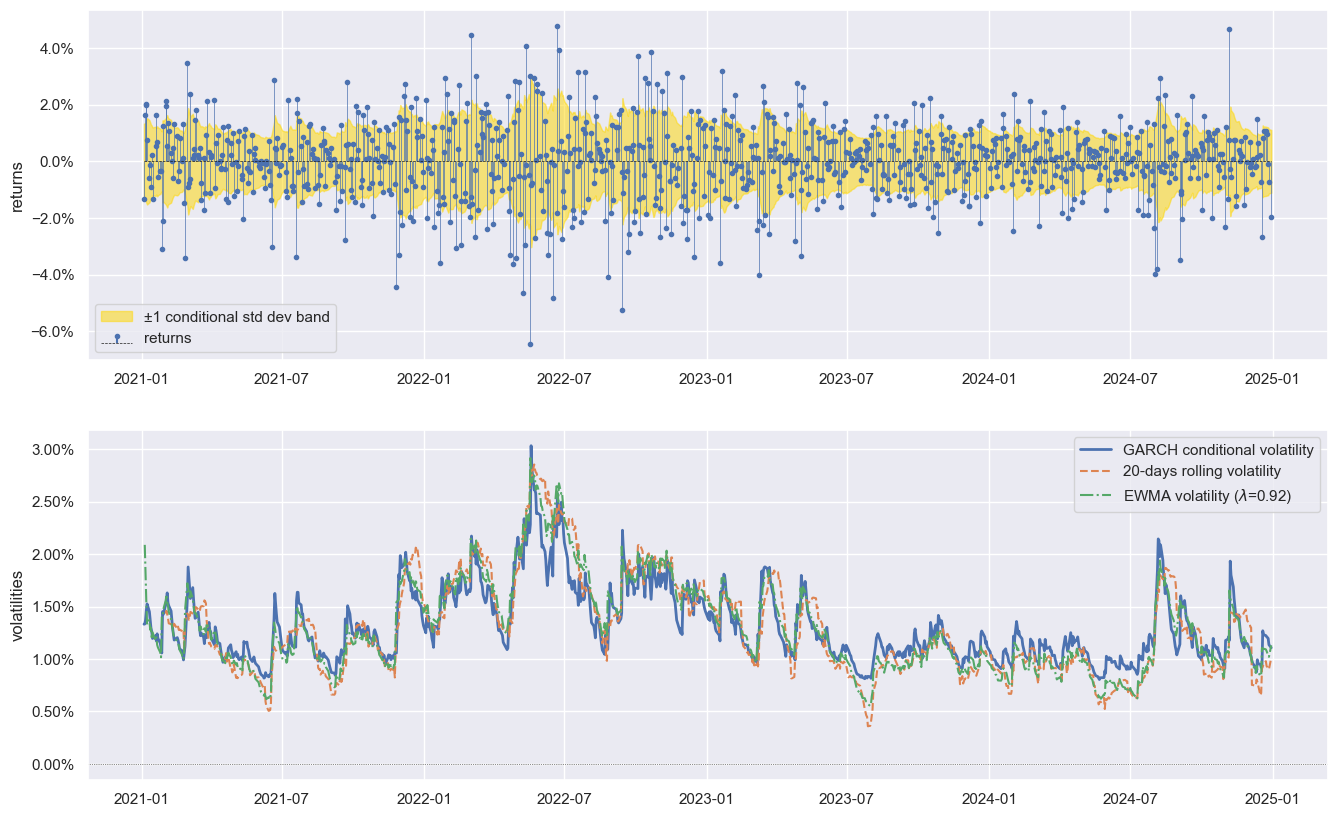

In [113]:
plot_volatilities(returns_2021)

# GARCH-weighted Historical Value-at-Risk

In [114]:
returns_2021['ret_GARCH_weighted'] = returns_2021['returns'] / returns_2021['cond_vol'] * returns_2021['cond_vol'].iloc[-1]
returns_2021.tail()

,returns,cond_vol,ret_GARCH_weighted
Date,,,
2024-12-23,0.010641,0.012236,0.009638
2024-12-24,0.009790,0.012136,0.008940
2024-12-26,-0.001122,0.011968,-0.001039
2024-12-27,-0.007170,0.011360,-0.006994
2024-12-30,-0.019554,0.011082,-0.019554


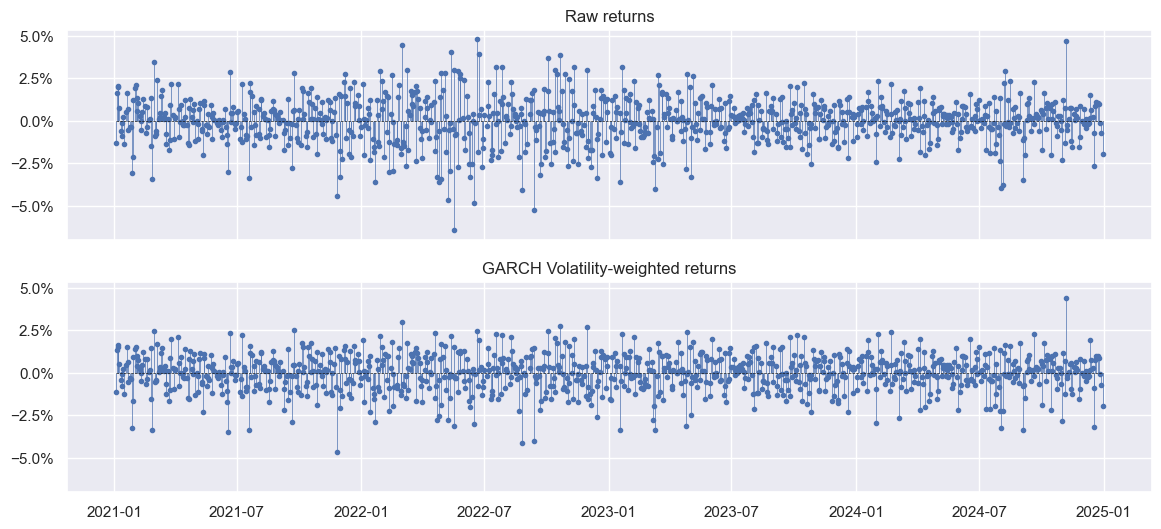

In [115]:
def plot_GARCH_weighted_returns(data):
    col_names = ['returns', 'ret_GARCH_weighted']
    labels = ["Raw returns", "GARCH Volatility-weighted returns"]

    fig, axs = plt.subplots(2, figsize=(14,6), sharex=True, sharey=True)
    for ax, name, label in zip(axs, col_names, labels):
        markerline, stemlines, baseline = ax.stem(data.index, data[name], label='returns')
        markerline.set(marker='.')
        stemlines.set(lw=0.5)
        baseline.set(c='k', ls='--', lw=0.5)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        ax.set_title(label)

plot_GARCH_weighted_returns(returns_2021)

In [116]:
returns_2021['loss_GARCH_weighted'] = -100 * returns_2021['ret_GARCH_weighted']
returns_2021.tail()

,returns,cond_vol,ret_GARCH_weighted,loss_GARCH_weighted
Date,,,,
2024-12-23,0.010641,0.012236,0.009638,-0.963775
2024-12-24,0.009790,0.012136,0.008940,-0.894007
2024-12-26,-0.001122,0.011968,-0.001039,0.103898
2024-12-27,-0.007170,0.011360,-0.006994,0.699421
2024-12-30,-0.019554,0.011082,-0.019554,1.955394


In [117]:
def GARCH_volatility_weighted_VaR(data, alpha):
    n = data.shape[0]
    quantile_pos = math.ceil(alpha * n)
    data_ordered = data.sort_values(by='loss_GARCH_weighted')
    VaR = data_ordered.iloc[quantile_pos].loc['loss_GARCH_weighted']
    print(f"The GARCH conditional volatility-weighted VaR at {alpha:.1%} confidence level is {VaR:.3f} m€")

GARCH_volatility_weighted_VaR(returns_2021, alpha=0.99)

The GARCH conditional volatility-weighted VaR at 99.0% confidence level is 3.249 m€


In [ ]:
for alpha in [0.9, 0.95, 0.99, 0.995]:
    GARCH_volatility_weighted_VaR(returns_2021, alpha=alpha)

The GARCH conditional volatility-weighted VaR at 90.0% confidence level is 1.380 m€
The GARCH conditional volatility-weighted VaR at 95.0% confidence level is 1.929 m€
The GARCH conditional volatility-weighted VaR at 99.0% confidence level is 3.249 m€
The GARCH conditional volatility-weighted VaR at 99.5% confidence level is 3.392 m€


# Volatility-weighted Historical Value-at-Risk from 20-days Rolling Volatility

In [120]:
def rolling_volatility_weighted_VaR(data, alpha, window):
    df = data.copy()  # Work on a copy to avoid modifying the original DataFrame

    # Compute rolling volatility
    df['rolling_vol'] = df['returns'].rolling(window).std()

    # Normalize returns by rolling volatility (scaling by last valid rolling vol)
    last_valid_vol = df['rolling_vol'].iloc[-1]
    df['ret_Rolling_weighted'] = df['returns'] / df['rolling_vol'] * last_valid_vol

    # Compute losses
    df['loss_Rolling_weighted'] = -100 * df['ret_Rolling_weighted']

    # Drop NaNs
    clean_data = df.dropna(subset=['loss_Rolling_weighted'])

    # Compute VaR
    n = clean_data.shape[0]
    quantile_pos = math.ceil(alpha * n)
    data_ordered = clean_data.sort_values(by='loss_Rolling_weighted')
    VaR = data_ordered.iloc[quantile_pos].loc['loss_Rolling_weighted']
    
    print(f"The {window}-day rolling volatility-weighted VaR at {alpha:.1%} confidence level is {VaR:.3f} m€")

rolling_volatility_weighted_VaR(returns_2021, alpha=0.99, window=20)


The 20-day rolling volatility-weighted VaR at 99.0% confidence level is 2.838 m€


# Volatility-weighted Historical Value-at-Risk from EWMA Volatility

In [123]:
def ewma_volatility_weighted_VaR(data, alpha, lambda_):
    df = data.copy()

    # Compute EWMA volatility directly using pandas
    df['ewma_vol'] = df['returns'].ewm(alpha=1 - lambda_).std()

    # Normalize returns (scaling to preserve units)
    last_valid_vol = df['ewma_vol'].iloc[-1]
    df['ret_EWMA_weighted'] = df['returns'] / df['ewma_vol'] * last_valid_vol

    # Compute losses
    df['loss_EWMA_weighted'] = -100 * df['ret_EWMA_weighted']

    # Drop NaNs
    clean_data = df.dropna(subset=['loss_EWMA_weighted'])

    # Compute VaR
    n = clean_data.shape[0]
    quantile_pos = math.ceil(alpha * n)
    data_ordered = clean_data.sort_values(by='loss_EWMA_weighted')
    VaR = data_ordered.iloc[quantile_pos].loc['loss_EWMA_weighted']

    print(f"The EWMA volatility-weighted VaR at {alpha:.1%} confidence level (λ={lambda_}) is {VaR:.3f} m€")


ewma_volatility_weighted_VaR(returns_2021, alpha=0.99, lambda_=0.92)

The EWMA volatility-weighted VaR at 99.0% confidence level (λ=0.92) is 2.699 m€


# Non weighted historical VaR (as a comparison). 

In [126]:
def historical_VaR(data, alpha):
    df = data.copy()
    
    # Compute losses (you may already have this column)
    df['loss'] = -100 * df['returns']

    # Sort and compute VaR
    n = df.shape[0]
    quantile_pos = math.ceil(alpha * n)
    data_ordered = df.sort_values(by='loss')
    VaR = data_ordered.iloc[quantile_pos].loc['loss']
    
    print(f"The non-weighted historical VaR at {alpha:.1%} confidence level is {VaR:.3f} m€")

historical_VaR(returns_2021, alpha=0.99)


The non-weighted historical VaR at 99.0% confidence level is 3.628 m€
